## Problem definition

- Informal: predict the price of the house based on historical data;
- Formal:
    - Task: Predict the sale price of a house based on given features;
    - Experience: A list of houses sold for the period 2006-2010;
    - Performace: mean absolute error, root mean squared error, statistical significance between predictions and true values;
    
## Assumptions

The main factors which might impact on price:
- Location;
- Lot size;
- Number of bedrooms;
- Number of bathrooms;
- Property conditions;

## Planned solution

### Data available
- Dataset;
- City Assessor website;
- Map of Ames;

### Data preparation
- Group featues by data type;
- Select the most relevant features within each group;
- Divide data on train, validation and test sets;
- Formatting, cleaning and engeneering;

### Solve the problem
- Using k-fold cross validation;
- Using MAE, RMSE and difference between means of predicted and true values;
- Test k-nearest neighbors and gradient discent algorithms on train and validation set, select the best one;
- Tune the best algorithm;

In [28]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error)
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFE
import scipy.stats
import itertools
import copy

pd.set_option('max_columns', 160)
pd.set_option('max_rows', 100)
pd.set_option('max_colwidth', 5000)
np.random.seed(1)

houses = pd.read_csv('AmesHousing.tsv', sep='\t')

## Getting familiar with the data

In [29]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

## Preparing data for analysis

### Working with missing values

In [30]:
missing_values = houses.isnull().sum() / houses.shape[0]
missing_values[missing_values > 0].sort_values(ascending=False)

Pool QC           0.995563
Misc Feature      0.963823
Alley             0.932423
Fence             0.804778
Fireplace Qu      0.485324
Lot Frontage      0.167235
Garage Yr Blt     0.054266
Garage Cond       0.054266
Garage Qual       0.054266
Garage Finish     0.054266
Garage Type       0.053584
Bsmt Exposure     0.028328
BsmtFin Type 2    0.027645
Bsmt Cond         0.027304
Bsmt Qual         0.027304
BsmtFin Type 1    0.027304
Mas Vnr Type      0.007850
Mas Vnr Area      0.007850
Bsmt Half Bath    0.000683
Bsmt Full Bath    0.000683
Garage Cars       0.000341
BsmtFin SF 2      0.000341
BsmtFin SF 1      0.000341
Bsmt Unf SF       0.000341
Total Bsmt SF     0.000341
Garage Area       0.000341
Electrical        0.000341
dtype: float64

### Data preparation

In [31]:
# Display dtypes
houses.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [32]:
# Group features 
disc_feat = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 
'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt',
'Garage Cars', 'Mo Sold', 'Yr Sold']

cont_feat = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1',
'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF',
'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area', 'Wood Deck SF', 
'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
'Pool Area']

ord_feat = ['Lot Shape', 'Utilities', 'Land Slope', 'Overall Qual',
'Overall Cond', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond',
'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC',
'Electrical', 'Kitchen Qual', 'Functional', 'Garage Finish', 
'Garage Qual', 'Garage Cond', 'Paved Drive']

nom_feat = ['MS SubClass', 'MS Zoning', 'Street', 'Land Contour', 'Lot Config',
'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
'Foundation', 'Heating', 'Central Air', 'Garage Type', ]

In [33]:
def train_and_val(data, target):
    # Split data to train and test
    div = int(data.shape[0] * 0.8)
    train = data.iloc[:div]
    test = data.iloc[div:]
    
    # Create a list of features
    feats = list(train.columns)
    feats.remove('SalePrice')
    
    # Instantiate models and kfold class
    knn = KNeighborsRegressor()#n_neighbors=k)
    lr = LinearRegression()
    kf = KFold(10, shuffle=True, random_state=1)
    
    # Print information on MAE and RMSE
    for name, model in [('KNN', knn), ('LR', lr)]:
        mses = cross_val_score(model, train[feats], train[target],
                              scoring = 'neg_mean_squared_error', cv=kf)
        maes = cross_val_score(model, train[feats], train[target],
                              scoring = 'neg_mean_absolute_error', cv=kf)
        avg_rmse = np.mean(np.sqrt(np.abs(mses)))
        avg_mae = np.mean(np.abs(maes))
        print('{0} RMSE: {1}'.format(name, avg_rmse))
        print('{0} MAE: {1}'.format(name, avg_mae))

In [34]:
# Selected manually based on data dictionary
nom_feat = ['Lot Config', 'Condition 1', 'Bldg Type', 'Central Air', 
            'Neighborhood', 'House Style', 'Roof Style', 'Exterior 1st',
            'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Garage Type']

# Update function definition
def drop_low_corr(data, feat, method, test_data=None):
    """ Drop columns with corellation coefficient less than
        0.5 and return dataset and features as index.
    """
    if test_data is not None:
        corr_coefs = np.abs(test_data[list(feat) + ['SalePrice']].corr(
        method=method)['SalePrice'])
    else:
        corr_coefs = np.abs(data[feat + ['SalePrice']].corr(
        method=method)['SalePrice'])
        
    data = data.drop(corr_coefs[corr_coefs < 0.5].index, axis=1)
    feat = corr_coefs[corr_coefs >= 0.5].index.drop('SalePrice')
    
    return data, feat

def mapping(data):
    test_data = data.copy()
    # Map for columns 'Bsmt Cond', 'Bsmt Qual', 'Exter Cond', 'Exter Qual',
    # 'Garage Cond', 'Garage Qual', 'Heating QC', 'Kitchen Qual'
    group1_map = {'Ex': 6, 'Fa': 3, 'Gd': 5, 'NoBsmt': 1,
                   'NoGrg': 1, 'Po': 2, 'TA': 4}
    group1_cols = ['Bsmt Cond', 'Bsmt Qual', 'Exter Cond', 'Exter Qual', 
                    'Garage Cond', 'Garage Qual', 'Heating QC',
                    'Kitchen Qual']
    for col in group1_cols:
        test_data[col] = test_data[col].map(group1_map)

    # Map for 'Bsmt Exposure'
    bsmt_exp_map = {'Av': 4, 'Gd': 5, 'Mn': 3, 'No': 2, 'NoBsmt': 1}
    test_data['Bsmt Exposure'] = test_data['Bsmt Exposure'].map(
        bsmt_exp_map)

    # Map for columns 'BsmtFin Type 1' and 'BsmtFin Type 2'
    bsmtfin_typ_map = {'ALQ': 6, 'BLQ': 5, 'GLQ': 7, 'LwQ': 3,
                       'NoBsmt': 1, 'Rec': 4, 'Unf': 2}
    for col in ['BsmtFin Type 1', 'BsmtFin Type 2']:
        test_data[col] = test_data[col].map(bsmtfin_typ_map)

    # Map for 'Functional':
    functional_map = {'Maj1': 4, 'Maj2': 3, 'Min1': 7, 'Min2': 6,
                      'Mod': 5, 'Sal': 1, 'Sev': 2, 'Typ': 8}
    test_data['Functional'] = test_data['Functional'].map(functional_map)

    # Map for 'Lot Shape'
    lot_shape_map = {'IR1': 3, 'IR2': 2, 'IR3': 1, 'Reg': 4}
    test_data['Lot Shape'] = test_data['Lot Shape'].map(lot_shape_map)

    # Map for 'Paved Drive'
    paved_drive_map = {'N': 1, 'P': 2, 'Y': 3}
    test_data['Paved Drive'] = test_data['Paved Drive'].map(
        paved_drive_map)
    return test_data
    
def select_features(data, cont_feat, disc_feat, ord_feat, nom_feat):
    # Copies need for several iterations
    data = data.copy()
    cont_feat = copy.deepcopy(cont_feat)
    disc_feat = copy.deepcopy(disc_feat)
    ord_feat = copy.deepcopy(ord_feat)
    nom_feat = copy.deepcopy(nom_feat)
    
    # Add columns
    data['Years_Sold'] = data['Yr Sold'] - data['Year Built']
    data['Years_Since_Remod'] = data['Yr Sold'] - data['Year Remod/Add']
    # Remove rows with negative values of these columns
    data = data[(data['Years_Sold'] >= 0) &
                (data['Years_Since_Remod'] >= 0)]
    # Append list of features
    cont_feat = cont_feat + ['Years_Sold', 'Years_Since_Remod']
    
    # Drop columns with percentage of missing values more than 45%
    missing_values = data.isnull().sum() / data.shape[0]
    data.drop(missing_values[missing_values > 0.45].index.tolist(),
                     axis=1, inplace=True)
    # Drop column and remove it from list
    data.drop(labels='Garage Yr Blt', axis=1, inplace=True)
    disc_feat.remove('Garage Yr Blt')
    # Drop rows with outliers in SalePrice column
    data = data[
        np.abs(data['SalePrice'] - data['SalePrice'].mean()
              ) <= 3*data['SalePrice'].std()]
    # Drop coumns with correlation less than 0.5
    data, cont_feat = drop_low_corr(data, cont_feat, 'pearson')
    data, disc_feat = drop_low_corr(data, disc_feat, 'spearman')
    
    # Fill nan values with Zero
    data[cont_feat] = data[cont_feat].fillna(0)
    data['Garage Cars'] = data['Garage Cars'].fillna(0)
    # Fill nan values for ordinal data
    cols = ['Garage Finish', 'Garage Qual', 'Garage Cond']
    data[cols] = data[cols].fillna('NoGrg')
    cols = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
            'BsmtFin Type 1', 'BsmtFin Type 2']
    data[cols] = data[cols].fillna('NoBsmt')
    data['Electrical'] = data['Electrical'].fillna('SBrkr')
    # Fill nan values for nominal data
    houses['Garage Type'] = houses['Garage Type'].fillna('NoGrg')
    houses['Mas Vnr Type'] = houses['Mas Vnr Type'].fillna('None')
    
    # Rescale data on continious columns
    back_up = data['Gr Liv Area'].copy()
    high = back_up.max()
    low = back_up.min()
    back_up = (back_up - low) / (high - low)
    data[cont_feat] = ((data[cont_feat] - data[cont_feat].min()) /
                   (data[cont_feat].max() - data[cont_feat].min()))
    data['Gr Liv Area'] = back_up
    
    # Cheking the number of unique values in each column
    low_var_cols = pd.Series(
        {col: data[col].value_counts(normalize=True).max()
         for col in ord_feat}
    )
    # Drop columns where % of unique values is greater than 95
    # (low variance)
    ord_feat = low_var_cols[low_var_cols < 0.95].index
    data.drop(low_var_cols[low_var_cols >= 0.95].index, axis=1,
                inplace=True)
    
    # Create a test dataset to test correlation
    test_data = mapping(data)
    test_cols = list(ord_feat) + ['SalePrice']
    test_cols.remove('Electrical')
    data, ord_feat = drop_low_corr(data, ord_feat, method='spearman',
                                   test_data=test_data)
    # Create a list of features
    feat = list(cont_feat
                .union(disc_feat)
                .union(ord_feat)
                .union(nom_feat)) + ['SalePrice']
    # Replace ordinal and nominal features with dummy variables
    data = pd.get_dummies(data[feat], columns=ord_feat.union(nom_feat))
    
    return data, feat

new_houses, new_feat = select_features(houses, cont_feat, 
                                    disc_feat, ord_feat, nom_feat)

new_houses = new_houses.loc[np.random.permutation(new_houses.index)]
train_and_val(new_houses, 'SalePrice')

KNN RMSE: 29719.937687220732
KNN MAE: 20619.08622623753
LR RMSE: 25124.5578877397
LR MAE: 16732.420338779502


### Model fitting

Try several configuration of knn and lr. For knn try the number of neighbors 1, 3, 5, 7, 9, 11, 13 and compare it's results with linear regression. 

In [35]:
def train_and_val(data, target, k):
    # Split data to train and test
    div = int(data.shape[0] * 0.8)
    train = data.iloc[:div]
    test = data.iloc[div:]
    
    # Create a list of features
    feats = list(train.columns)
    feats.remove('SalePrice')
    
    # Instantiate models and kfold class
    knn = KNeighborsRegressor(n_neighbors=k)
    lr = LinearRegression()
    kf = KFold(10, shuffle=True, random_state=1)
    
    # Print information on MAE and RMSE
    for name, model in [('KNN', knn), ('LR', lr)]:
        mses = cross_val_score(model, train[feats], train[target],
                              scoring = 'neg_mean_squared_error', cv=kf)
        maes = cross_val_score(model, train[feats], train[target],
                              scoring = 'neg_mean_absolute_error', cv=kf)
        avg_rmse = np.mean(np.sqrt(np.abs(mses)))
        avg_mae = np.mean(np.abs(maes))
        print('{0} RMSE: {1}'.format(name, avg_rmse))
        print('{0} MAE: {1}'.format(name, avg_mae))
        
for k in range(1, 16, 2):
    print('The number of neighbors is {}.'.format(k))
    train_and_val(new_houses, 'SalePrice', k)
    print('<-------------------------------->')

The number of neighbors is 1.
KNN RMSE: 37223.75147631204
KNN MAE: 25689.985383022773
LR RMSE: 25124.5578877397
LR MAE: 16732.420338779502
<-------------------------------->
The number of neighbors is 3.
KNN RMSE: 30140.931176554448
KNN MAE: 21108.735445761966
LR RMSE: 25124.5578877397
LR MAE: 16732.420338779502
<-------------------------------->
The number of neighbors is 5.
KNN RMSE: 29719.937687220732
KNN MAE: 20619.08622623753
LR RMSE: 25124.5578877397
LR MAE: 16732.420338779502
<-------------------------------->
The number of neighbors is 7.
KNN RMSE: 29300.321096238506
KNN MAE: 20238.338725229223
LR RMSE: 25124.5578877397
LR MAE: 16732.420338779502
<-------------------------------->
The number of neighbors is 9.
KNN RMSE: 29331.29522028088
KNN MAE: 20261.35760231717
LR RMSE: 25124.5578877397
LR MAE: 16732.420338779502
<-------------------------------->
The number of neighbors is 11.
KNN RMSE: 29398.28142234659
KNN MAE: 20320.597427236797
LR RMSE: 25124.5578877397
LR MAE: 16732.42

No improvements in model's performance. We will proceed with linear regression. Let's check our model on test data set. I didn't find any hyperparameter optimization for leaner regression. So, let's verify our model on test data set. 

In [36]:
def train_and_test(data, target):
    # Split data to train and test
    div = int(data.shape[0] * 0.8)
    train = data.iloc[:div]
    test = data.iloc[div:]
    
    # Create a list of features
    feats = list(train.columns)
    feats.remove('SalePrice')
    
    lr = LinearRegression()
    lr.fit(train[feats], train['SalePrice'])
    predictions = lr.predict(test[feats])
    maes = mean_squared_error(test['SalePrice'], predictions)
    
    return maes**0.5

print(train_and_test(new_houses, 'SalePrice'))
print(new_feat)

22153.32739817816
['1st Flr SF', 'Bldg Type', 'Bsmt Qual', 'Central Air', 'Condition 1', 'Exter Qual', 'Exterior 1st', 'Exterior 2nd', 'Fireplaces', 'Foundation', 'Full Bath', 'Garage Area', 'Garage Cars', 'Garage Type', 'Gr Liv Area', 'Heating QC', 'House Style', 'Kitchen Qual', 'Lot Config', 'Mas Vnr Type', 'Neighborhood', 'Overall Qual', 'Roof Style', 'Total Bsmt SF', 'Years_Since_Remod', 'Years_Sold', 'SalePrice']


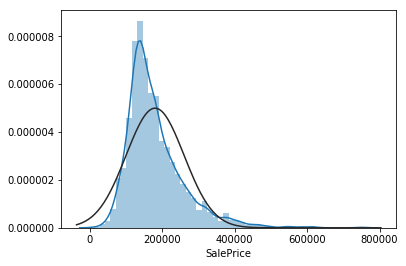

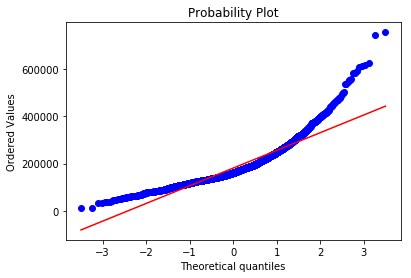

In [46]:
test_set = houses.copy()
sns.distplot(test_set['SalePrice'], fit=scipy.stats.norm)
plt.show()
scipy.stats.probplot(test_set['SalePrice'], plot=plt)
plt.show()

In [48]:
test_set['SalePrice'] = np.log(test_set['SalePrice'])
new_set, new_set_feats = select_features(test_set, cont_feat, disc_feat, ord_feat, nom_feat)
new_set = new_set.loc[np.random.permutation(new_set.index)]

In [49]:
train_and_test(new_set, 'SalePrice')

0.12236985036892596

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


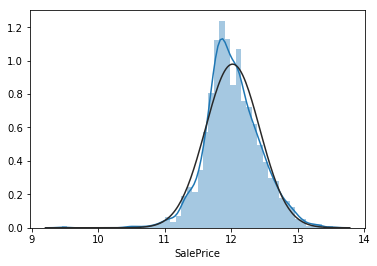

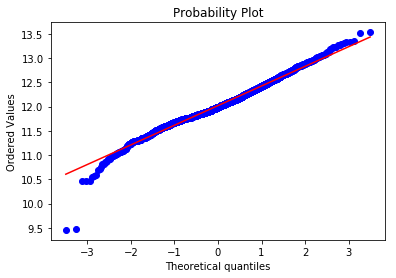

In [50]:
sns.distplot(test_set['SalePrice'], fit=scipy.stats.norm)
plt.show()
scipy.stats.probplot(test_set['SalePrice'], plot=plt)
plt.show()